## Titanic - Machine Learning from Disaster


| Column     | Description |
|------------|-------------|
| PassengerId | An unique index for passenger rows |
| Survived    | Indicates if the passenger survived or not (1 - yes, 0 - no) |
| Pclass      | Ticket class (1 - 1st, 2 - 2nd, 3 - 3rd) |
| Name        | Name of the passenger |
| Sex         | Sex of the passenger |
| Age         | Age of the passenger |
| SibSp       | Number of siblings/spouses aboard |
| Parch       | Number of parents/children aboard |
| Ticket      | Ticket number of the passenger |
| Fare        | Fare paid by the passenger |
| Cabin       | Cabin number of the passenger |
| Embarked    | Port of embarkation (C - Cherbourg, S - Southampton, Q - Queenstown) |

In [1]:
import pandas as pd
import re

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df.shape

(891, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
228,229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
111,112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C
773,774,0,3,"Elias, Mr. Dibo",male,NaN,0,0,2674,7.2250,NaN,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
580,581,1,2,"Christy, Miss. Julie Rachel",female,25.0,1,1,237789,30.0000,NaN,S


In [6]:
df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Basic cleaning

In [8]:
# Dropping unnecessary columns

df = df.drop(columns = ["PassengerId", "Cabin", "Ticket"])

# Extract Title from Name, clean it and drop Name 

df['Title'] = df['Name'].apply(lambda x: re.findall(r'\b\w+\.', x)[0])
df['Title'] = df['Title'].replace(["Lady.", "Mme."], "Mrs.").replace(["Mlle.", "Ms."], "Miss.")
df['Title'] = df['Title'].apply(lambda x: x if x in (["Mr.", "Miss.", "Mrs.", "Master."]) else "Other")
df.drop(columns = ["Name"], inplace = True)

# Fillna Age using mean age by Title and Pclass

mean_ages_dict  = df.groupby(['Title', 'Pclass'])['Age'].mean().to_dict()
df['Age'] = df.apply(lambda row: mean_ages_dict[(row['Title'], row['Pclass'])] if pd.isna(row['Age']) else row['Age'], axis=1)


#### Basic FE

In [9]:
df.sample(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
485,0,3,female,16.123188,3,1,25.4667,S,Miss.


In [10]:
# Create new variable FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create new variable IsAlone
df['IsAlone'] = 1
df.loc[(df['FamilySize'] > 1), 'IsAlone'] = 0

In [11]:
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Pclass', 'Sex', "Embarked", 'Title', 'IsAlone']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

transformed_data  = preprocessor.fit_transform(df)

In [12]:
# Get feature names for the one-hot encoded categorical columns
onehot_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine with the numeric features' names
all_feature_names = numeric_features + list(onehot_features)

# Create a new DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

# If the original DataFrame contains a target variable (e.g., 'Survived'), add it back
if 'Survived' in df.columns:
    transformed_df['Survived'] = df['Survived'].values

In [13]:
transformed_df.head(1)

,Age,Fare,SibSp,Parch,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Embarked_S,Embarked_missing,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,IsAlone_0,IsAlone_1,Survived
0,-0.548524,-0.502445,0.432793,-0.473674,0.05916,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


#### Modeling

In [14]:
# Assuming transformed_df is your DataFrame after transformation
X = transformed_df.drop('Survived', axis=1)  # or your target variable
y = transformed_df['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Gender Baseline Model 
preds = X_test['Sex_female'].astype('int')
accuracy = accuracy_score(preds, y_test)
accuracy

0.7821229050279329

In [16]:
# Training a ML Model 
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [17]:
accuracy_score(y_pred, y_test)

0.8491620111731844

In [18]:
# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values 
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 1421/1424 [00:20<00:00]        

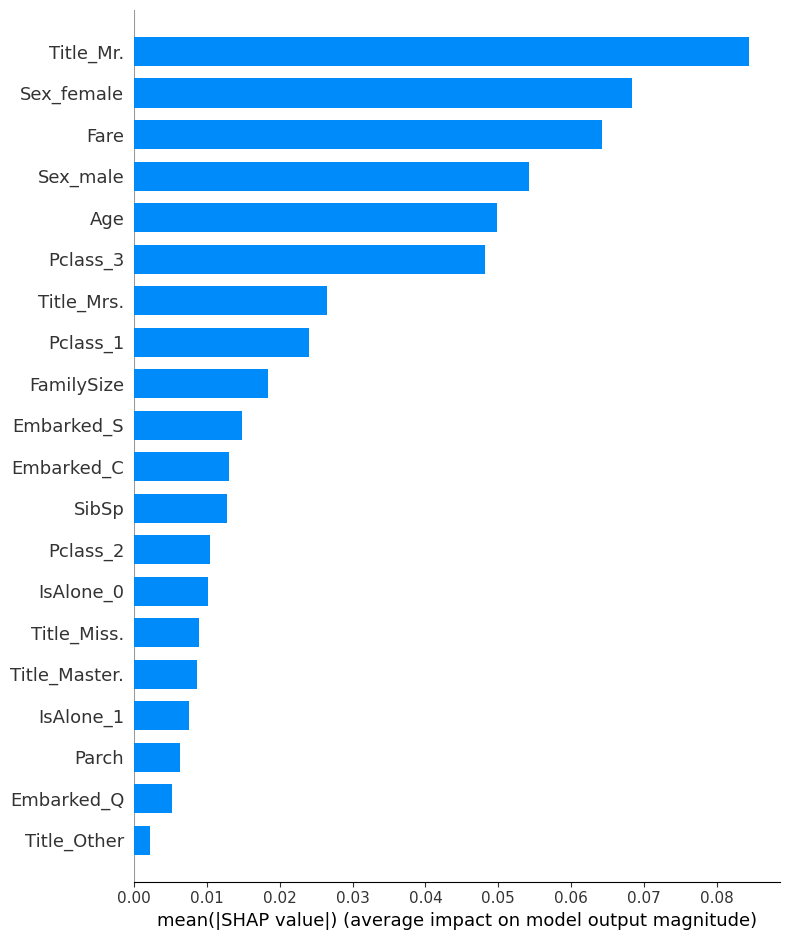

In [19]:
shap.summary_plot(shap_values[:, :, 1], X_train, plot_type="bar")

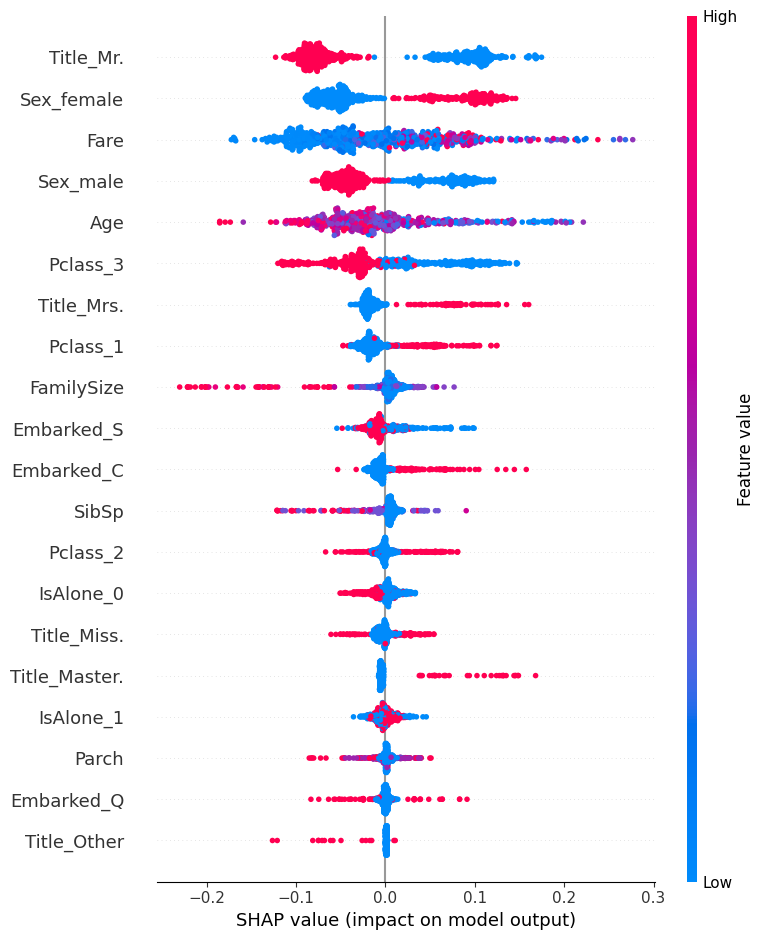

In [20]:
# Summarize the effects of all the features
shap.summary_plot(shap_values[:, :, 1], X_train)

### Answering questions: 
1. Your evaluation metrics and the explanation of them: _Is this a good model? A bad one? Why?:

I think it's a good model. The reason is that the accuracy obtained by the base model is 0.78, which means that it correctly predicts 78% of the total test cases. While the Random Forest approach with the feature cleaning and engineering processed reaches 85%, so we obtain an accuracy improvement of 7% over the base model. 


2. What are the most important features for the ML model: _All the features are equally important? What are the most useful ones? Why?_

Looking at the SHAP values graph, we see that variables such as Title_MR, Sex_male, and Pclass_3 are very good predictors of whether the person did NOT survive. While Sex_female, Fare, Title_Mrs, and PClass_1 are very good predictors for defining whether the person survived. 

Variables such as age turn out to be very important for the model but have a mixed effect on the final output of the model.

3. An explanation of how we can put on production the model (please mention the technologies that you'd use and MLOps best practices): _What system architecture you'd use? How we can automate stuff? Which cloud services you'd use? Why?_

I think we can use the best practices followed in this approach. Using OOP is a good practice to make the code scalable and maintainable over time. The versioning would be kept, but I would add using DVC to also version the data and pipelines used for processing. I would keep the use of Poetry for dependency management and environment control. Use libraries like black, isort for formatting, flake8 for linting and mypi to check static typing. To maintain quality standards in the package and streamline the testing, building, and deployment phases I would use some CI/CD tool, like GitHubActions. 

In addition, I would package the project in a Docker container, adding images that allow monitoring and serving such as MLFlow, I would also add some practical interface to make inferences easily using FastAPI for examples. 
 
To deploy the model I would use either services on AWS or GCP. I could do it from a compute service such as an EC2 or Google Compute Engine to allow inferences by external users. To store datasets, models, records I would use S3 or google cloud sto

Also, AWS SageMaker is a viable option for end-to-end deployment, providing an extensive toolkit for building, training, and deploying machine learning models at scaleeMaker. 